In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from tqdm import tqdm
pd.set_option('display.max_columns', None)


In [60]:
df = pd.read_csv("Electric_Production.csv")
df.columns = ['Date', 'IPG']

In [61]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by = "Date")

<Axes: xlabel='Date'>

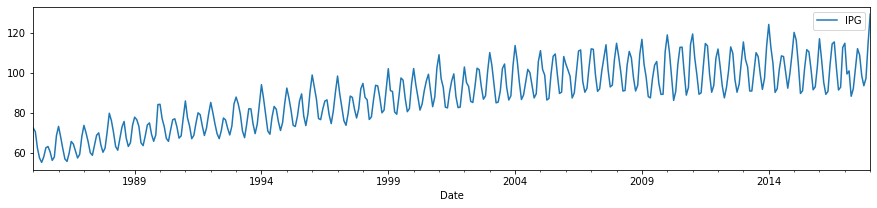

In [62]:
df.plot(x='Date', y='IPG', figsize=(15, 3))

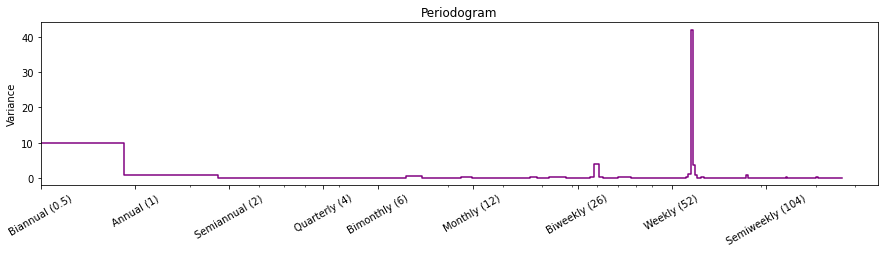

In [63]:
freqencies, spectrum = periodogram(
        df['IPG'],
        fs=730,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

plt.figure(figsize=(15, 3))
plt.step(freqencies, spectrum, color="purple")
plt.xscale("log")
plt.xticks([1, 2, 4, 8, 12, 24, 52, 104, 208],
          [
        "Biannual (0.5)",
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)"
    ],rotation=30)
plt.ylabel("Variance")
plt.title("Periodogram")
plt.show()

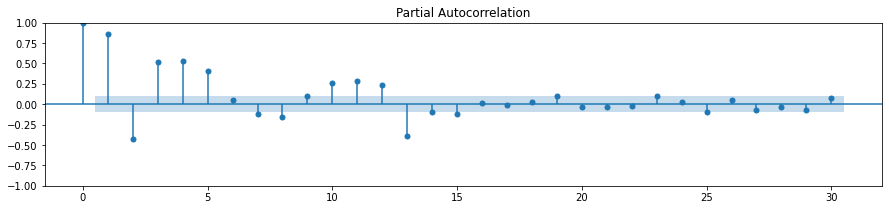

In [64]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
plot_pacf(df['IPG'], lags=30, ax=ax)
plt.show()

In [69]:
def forecast(dataframe, days):

    future = pd.DataFrame(columns = dataframe.columns)
    future['Date'] = pd.date_range(dataframe['Date'].iloc[-1]+pd.Timedelta(1, "D"), dataframe['Date'].iloc[-1]+pd.Timedelta(days, "D"))
    df = pd.concat([dataframe, future])

    # Time feature creation
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.day_of_week
    
    # Days and trend
    dates = df['Date'].unique()
    days = np.arange(1, len(dates)+1)
    days = pd.DataFrame({"Date":dates, "Day":days})
    df = df.merge(days, on="Date", how="left")
    df['Trend'] = np.sqrt(df['Day'])
    
    # Seasonality features
    Seasonality = dict(zip(
        (3.5, 7, 14, 365, 730, 1095),
        ('Semiweek', 'Week', 'Biweek', 'Annual', 'BiAnnual', 'TriAnnual')
    ))
    for s, n in Seasonality.items():
        df[f'sin_{n}'] = np.sin(df['Day'] * (2*np.pi / s))
        df[f'cos_{n}'] = np.cos(df['Day'] * (2*np.pi / s))
        
    # Lag features
    lags = [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13]
    lagged = pd.concat({
        f'lag_{lag}': df['IPG'].shift(lag) for lag in lags
    }, axis=1)
    
    
    df = pd.concat([df, lagged], axis=1)[lags[-1]:]

    X = df.dropna().drop(columns = ['IPG', 'Date'])
    y = df.dropna()['IPG']

    model = Ridge()
    model.fit(X, y)
    
    for i in (range(df[df['IPG'].isna()]['Date'].nunique())):
        date_X = df[df['IPG'].isna()]['Date'].iloc[0]
        lead_X = df[df['Date'] == date_X]
#         display(lead_X)
        lead_1 = model.predict(lead_X.drop(columns = ['IPG', 'Date']))[0]

        try:
            df.loc[lead_X.index, 'IPG'] = lead_1
        except Exception as e:
            pass

        for lag in lags:
            index = df[df['Date'] == date_X + pd.Timedelta(lag, 'D')].index
            try:
                df.loc[index, f'lag_{lag}'] = lead_1
            except Exception as e:
                pass
            
    pred = df.iloc[-len(future):].set_index("Date")['IPG']
    return pred

<Axes: xlabel='Date'>

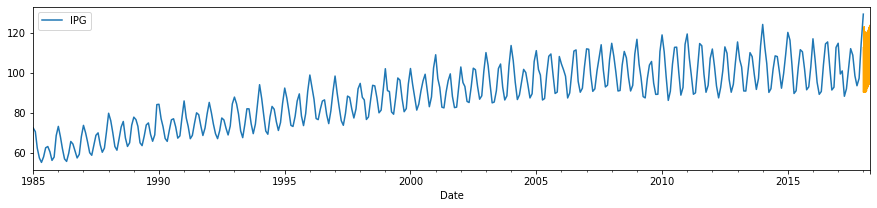

In [75]:
ax = df.plot(x='Date', y='IPG', figsize=(15, 3))
forecast(df, 100).plot(ax = ax, c = 'orange')

In [ ]:
X = df.drop(columns = "IPG")
y = df['IPG']

from sklearn.preprocessing import StandardScaler

features = X.columns.values
dates = X.index.values

Scaler = StandardScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns=features, index=dates)


n = len(X)
X_train = X[:int(0.7*n)]
y_train = y[:int(0.7*n)]
X_valid = X[int(0.7*n):]
y_valid = y[int(0.7*n):]

In [ ]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

model = Ridge()
model.fit(X_train, y_train)

print("Training error: ", model.score(X_train, y_train))
print("Test error: ", model.score(X_valid, y_valid))

In [ ]:
y_pred = pd.Series(model.predict(X_valid), index = X_valid.index)

In [ ]:
ax = y_train.plot(figsize=(15, 3), c='tab:blue')
y_valid.plot(ax = ax, c='tab:blue', alpha=0.3)
y_pred.plot(ax=ax, c='orange')